In [1]:
%pip install -qU langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph

Note: you may need to restart the kernel to use updated packages.


In [25]:
# langsmith
import os
from getpass import getpass

key = getpass()

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = key
os.environ["LANGCHAIN_PROJECT"] = "default"

In [26]:
key=getpass()

# tavily
os.environ["TAVILY_API_KEY"] = key

In [27]:
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import MarkdownHeaderTextSplitter
import uuid

file_path = os.path.join('data', 'data.md')
with open(file_path, 'r', encoding='utf-8') as file:
    docs_string = file.read()

# Split the document into chunks base on markdown headers.
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]
text_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
doc_splits = text_splitter.split_text(docs_string)

# add to vector store
random_directory = "./" + str(uuid.uuid4())

key = getpass()

embedding = OpenAIEmbeddings(
    model="text-embedding-3-small", 
    openai_api_key=key,
    openai_api_base="https://api.apiyi.com/v1")

vectorstore = Chroma.from_documents(documents=doc_splits, embedding=embedding, persist_directory=random_directory, collection_name="rag-chroma",)
retriever = vectorstore.as_retriever()

### Retrieve + Grade

In [28]:
### determine similarity or relevant btw doc & user query
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")
    
llm = ChatOpenAI(
        model="gpt-4o-mini",
        api_key=key,
        base_url="https://api.apiyi.com/v1",
        temperature=0)

# structured output
structured_llm_grader = llm.with_structured_output(GradeDocuments)  

# build prompt template from msg
system = """
You are an evaluator responsible for assessing the relevance of retrieved documents to user queries. \n
The testing does not need to be very strict. The goal is to filter out irrelevant retrievals. \n
If the document contains keywords or semantic meanings related to the user query, rate it as relevant. \n
Provide a binary score of "yes" or "no" to indicate whether the document is relevant to the query.
"""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# chain prompt to llm
retrieval_grader = grade_prompt | structured_llm_grader
# relevant query
question = "who is in charge of payment_backend?"
# irrelevant query
#question = "Today's weather in Shanghai"

# retrieve
docs = retriever.invoke(question)

# grade for each doc
for doc in docs:
    print("doc: \n", doc.page_content, "\n")
    print(retrieval_grader.invoke({"question": question, "document": doc.page_content}))
    print("\n")

doc: 
 Microservice Managers:  
- **payment_frontend**: Alice, Contact: 123
- **payment_gateway**: Bob, Contact: 456
- **payment_backend**: Bob, Contact: 789
- **payment_callback**: Cindy, Contact: 101112  
If you need any further assistance, feel free to ask! 

binary_score='yes'


doc: 
 - **Problem Description**: The processing time for user payment requests exceeds the normal range.
- **Possible Causes**:
- Insufficient system resources
- Inefficient database queries
- Slow response from external services
- **Solutions**:
- Increase system resources such as CPU and memory.
- Optimize database queries by using indexes and reducing complex queries.
- Communicate with external service providers to optimize interface performance. 

binary_score='no'


doc: 
 - **Problem Description**: The payment system is completely inaccessible or the service is interrupted.
- **Possible Causes**:
- Hardware failure of the host
- System software crash
- Network device failure
- **Solutions**:
- Quick

### Generate

In [29]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# rag prompt
prompt = hub.pull("rlm/rag-prompt")

# llm
llm = ChatOpenAI(
    model_name="gpt-4o-mini",
    api_key=key,
    base_url="https://api.apiyi.com/v1",
    temperature=0)

# post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

Bob is in charge of the payment_backend.


### Hallucination?

In [30]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(description="Answer is grounded in the facts, 'yes' or 'no'")

# LLM with function call
llm = ChatOpenAI(
    model_name="gpt-4o-mini",
    api_key=key,
    base_url="https://api.apiyi.com/v1",
    temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# build prompt template from msg
system = """
You are an evaluator assessing whether the LLM generation is based on or supported by a set of retrieved facts. \n
Provide a binary score of "yes" or "no." \n
"Yes" indicates that the answer is based on or supported by a set of facts.
"""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

# chain
hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

### Answer the question?

In [31]:
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(description="Answer addresses the question, 'yes' or 'no'")


# LLM with function call
llm = ChatOpenAI(
    model_name="gpt-4o-mini",
    api_key=key,
    base_url="https://api.apiyi.com/v1",
    temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """
You are an evaluator assessing whether the answer addresses a specific question. \n
Provide a binary score of "yes" or "no." \n
"Yes" indicates that the answer resolves the question.
"""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

### Rewrite

In [32]:
# llm
llm = ChatOpenAI(
    model_name="gpt-4o-mini",
    api_key=key,
    base_url="https://api.apiyi.com/v1",
    temperature=0)

# prompt
system = """
You have a question rewriter that can transform the input question into a better version optimized for vector store retrieval. \n
Review the input and try to infer the underlying semantic intent/meaning, responding in the user's language.
"""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'Who is responsible for managing the payment backend?'

### Node

In [33]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [34]:
# nodes

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("----GRADE----\n")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("Doc is relevant to question.\n")
            filtered_docs.append(d)
        else:
            print("Doc is irrelevant to question.\n")
            continue
    return {"documents": filtered_docs, "question": question}

def rewrite_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("----REWRITE----\n")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    print("Question after re-write: ", better_question)
    return {"documents": documents, "question": better_question}


### Edges
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("----GENERATE----\n")
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("All docs are irrelevant，re-write question\n")
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("Doc is relevant to question, start to generate answer.\n")
        return "generate"


# has hallucination?
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("----HALLUCINATION?----\n")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("No hallucination.\n")
        # 评估LLM 的回答是否解决了用户问题
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("Question is solved.\n")
            return "useful"
        else:
            print("Question is not solved.\n")
            return "not useful"
    else:
        print("Has hallucination, re-generate……\n")
        return "not supported"

In [35]:
from typing import Literal

class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(..., description="Given a user question choose to route it to web search or a vectorstore.",)
    
def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    llm = ChatOpenAI(
        model_name="gpt-4o-mini",
        api_key=key,
        base_url="https://api.apiyi.com/v1",
        temperature=0)
    structured_llm_router = llm.with_structured_output(RouteQuery)

    # Prompt
    system = """
    You are an expert in routing user questions to either vectorstore or web_search. \n
    Use vectorstore to answer questions related to operations, tickets, microservices, gateways, workloads, logs, and similar topics. \n
    For all other inquiries, use web_search.
    """
    route_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "{question}"),
        ]
    )

    question_router = route_prompt | structured_llm_router
    print("---ROUTE---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE TO WEB-SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE TO VECTORSTORE---")
        return "vectorstore"

In [37]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.schema import Document

web_search_tool = TavilySearchResults(k=3)

def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB-SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}

### Graph

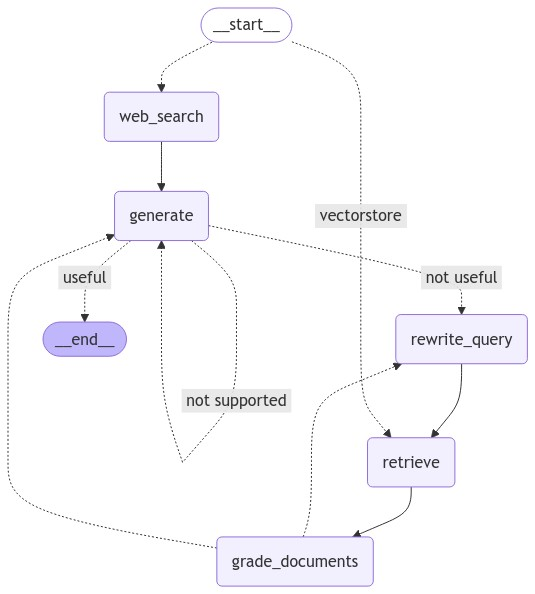

In [38]:
from langgraph.graph import END, StateGraph, START
from IPython.display import Image, display

workflow = StateGraph(GraphState)

# ++
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve) 
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("rewrite_query", rewrite_query)

# DCG
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
# Add conditional edges to grade_documents to determine the result of the decide_to_generate function.
# If the function returns "transform_query," transition to the transform_query node.
# If the function returns "generate," transition to the generate node.
workflow.add_conditional_edges(
    "grade_documents",
    # cond
    decide_to_generate,
    {
        "rewrite_query": "rewrite_query",
        "generate": "generate",
    },
)
workflow.add_edge("rewrite_query", "retrieve")
# Add conditional edges to generate to determine the result of the grade_generation_v_documents_and_question function.
# If the function returns "useful," transition to the END node.
# If the function returns "not useful," transition to the transform_query node.
# If the function returns "not supported," transition to the generate node.
workflow.add_conditional_edges(
    "generate",
    # cond
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "rewrite_query",
    },
)
# Compile
app = workflow.compile()

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [39]:
from pprint import pprint

# inputs = {"question": "Who is charge of most payment services?"}
inputs = {"question": "Today's weather in Shanghai."}

for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE---
---ROUTE TO WEB-SEARCH---
---WEB-SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---
----HALLUCINATION?----

No hallucination.

Question is solved.

"Node 'generate':"
'\n---\n'
("Today's weather in Shanghai is sunny with a temperature of 30°C (86°F). The "
 'wind is coming from the ENE at 10.1 mph, and humidity is at 52%. There is no '
 'precipitation expected.')
